In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

In [2]:
current_year = 2024

new_resales = pd.read_csv('new_resales.csv')

regression_columns = ['year', 'flat_type', 'storey_range', 'town',
                      'remaining_lease', 'floor_area_sqm', 'resale_price']

### Checking for hints of multicollinearity

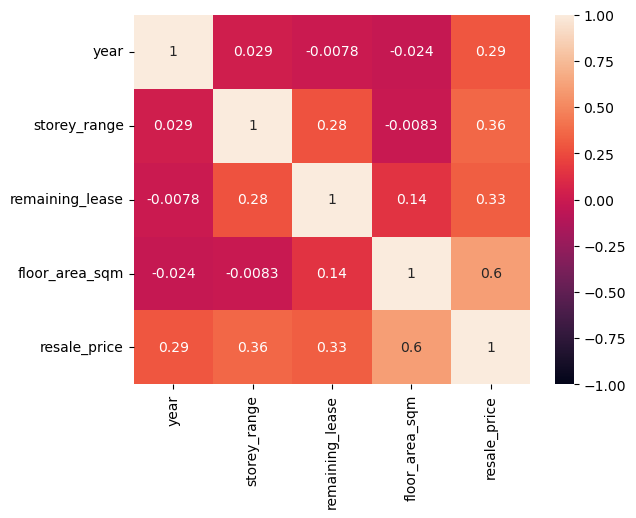

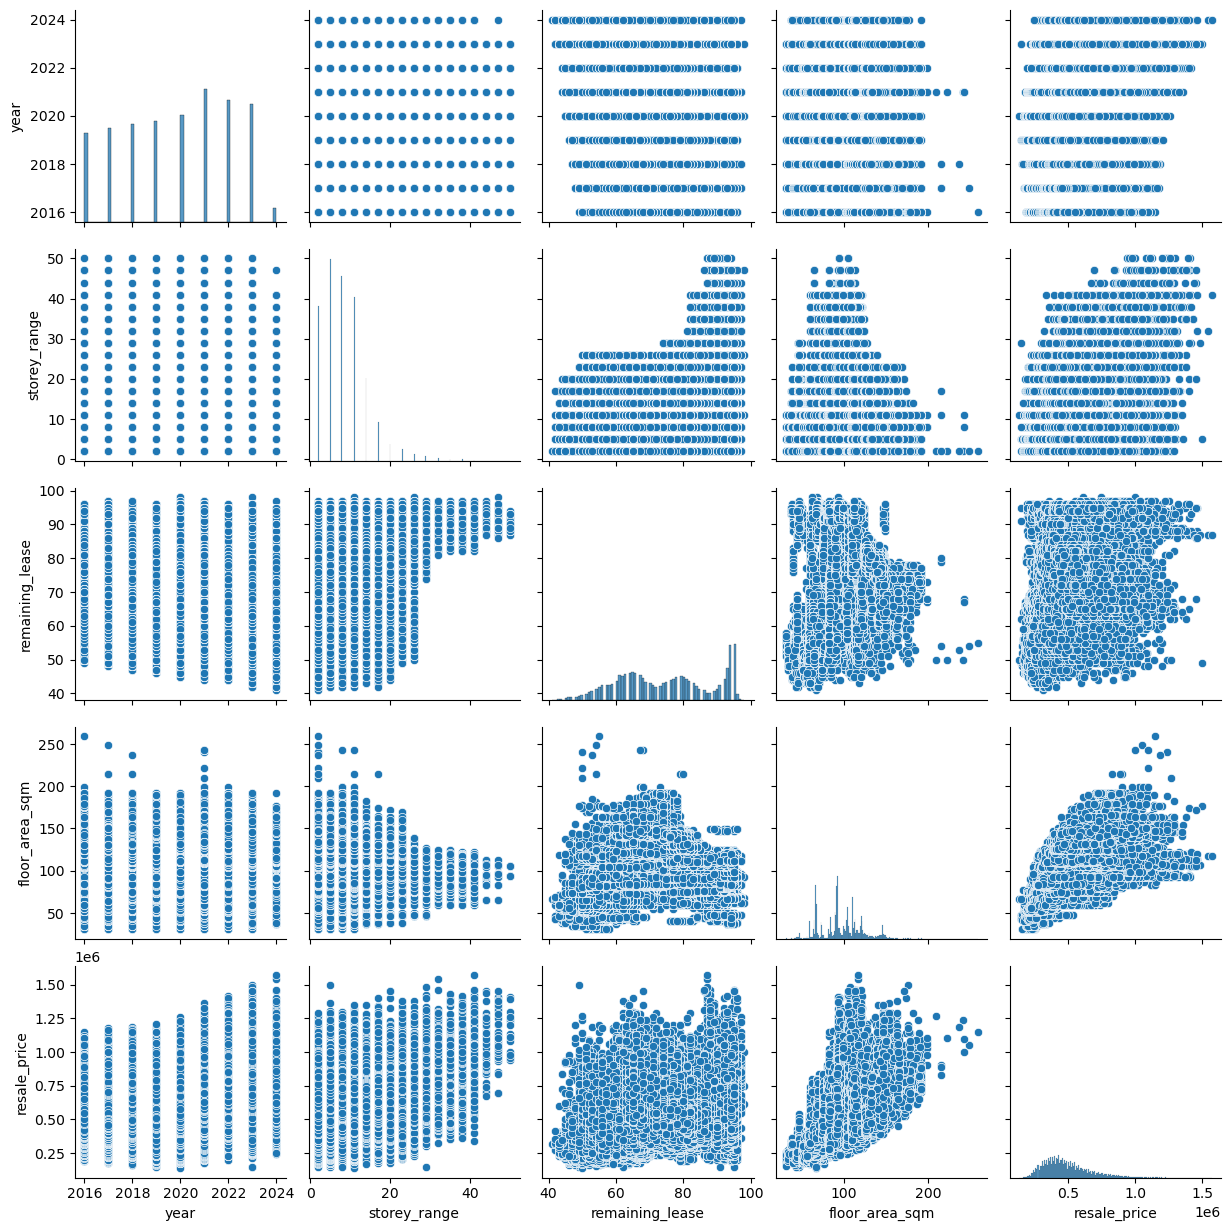

In [3]:
new_resales_reg = new_resales[regression_columns]

sns.heatmap(new_resales_reg.corr(), vmin=-1, vmax=1, annot=True)
sns.pairplot(new_resales_reg)

## There is slight posiive correlation between storey range and remaining lease actually.
## Probably due to newer flats having higher floors. 
## Probably not big enough to cause multicollinearity issues.

### Data Preprocessing

In [4]:
original_col = pd.get_dummies(new_resales_reg).columns
new_resales_reg = pd.get_dummies(new_resales_reg, drop_first=True)
# new_resales_reg  = pd.get_dummies(new_resales_reg).drop(columns=['flat_type_2 ROOM', 'town_ANG MO KIO'])  
# Uncomment above to try other dummy variables
dummy_var = set(original_col) - set(new_resales_reg.columns)

# Rename some columns to get smf.ols to read x variables properly
new_resales_reg.columns = new_resales_reg.columns.str.replace(' ','_')
new_resales_reg.rename(columns={'price/sqm':'Price_per_sqm',
                                'town_KALLANG/WHAMPOA':'town_KALLANG_WHAMPOA',
                                'flat_type_MULTI-GENERATION':'flat_type_MULTI_GENERATION'},
                       inplace=True)

# Subtract year by 2024 to simplify analysis of coefficients
new_resales_reg['year'] = new_resales_reg['year'] - current_year


### Regression: Simple

In [5]:
x_variables = list(new_resales_reg.columns)
y_variable = 'resale_price'

try: x_variables.remove(y_variable)
except ValueError: pass

# Exporting the correlation matrix, too large to visualize
new_resales_reg[x_variables].corr().to_csv('correl.csv')

linear_model = smf.ols(data=new_resales_reg, formula=f'{y_variable} ~ {"+".join(x_variables)}').fit()
print(linear_model.summary())
print(f'Dummy Variables: {dummy_var}')

# Adj R2 0.86, Non-Significant Variables: 2 Room

                            OLS Regression Results                            
Dep. Variable:           resale_price   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                 2.722e+04
Date:                Mon, 25 Mar 2024   Prob (F-statistic):               0.00
Time:                        17:06:28   Log-Likelihood:            -2.4062e+06
No. Observations:              191586   AIC:                         4.813e+06
Df Residuals:                  191550   BIC:                         4.813e+06
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

### Regression: Changing y variable to log

In [6]:
linear_model = smf.ols(data=new_resales_reg, formula=f'np.log({y_variable}) ~ {"+".join(x_variables)}').fit()
print(linear_model.summary())
print(f'Dummy Variables: {dummy_var}')

# Adj R2 0.897, all variables significant. 
# Since R2 increased significantly, we keep log(y)

                             OLS Regression Results                             
Dep. Variable:     np.log(resale_price)   R-squared:                       0.862
Model:                              OLS   Adj. R-squared:                  0.862
Method:                   Least Squares   F-statistic:                 3.427e+04
Date:                  Mon, 25 Mar 2024   Prob (F-statistic):               0.00
Time:                          17:06:29   Log-Likelihood:             1.2864e+05
No. Observations:                191586   AIC:                        -2.572e+05
Df Residuals:                    191550   BIC:                        -2.568e+05
Df Model:                            35                                         
Covariance Type:              nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------


### Regression: Adding quadratic terms to numerical variables

In [7]:
var = ['storey_range', 'remaining_lease', 'floor_area_sqm']
string = ''.join(map(lambda x: ' + I(' + x + '**2)', var))

linear_model = smf.ols(data=new_resales_reg, 
    formula=f'np.log({y_variable}) ~ {"+".join(x_variables)}' + string).fit()
print(linear_model.summary())
print(f'Dummy Variables: {dummy_var}')

# Adj R2 0.898, storey_range ** 2 not significant
# Because there is no significant increase in R2, we prefer model simplicity hence we drop the quadratic terms

                             OLS Regression Results                             
Dep. Variable:     np.log(resale_price)   R-squared:                       0.863
Model:                              OLS   Adj. R-squared:                  0.863
Method:                   Least Squares   F-statistic:                 3.168e+04
Date:                  Mon, 25 Mar 2024   Prob (F-statistic):               0.00
Time:                          17:06:29   Log-Likelihood:             1.2895e+05
No. Observations:                191586   AIC:                        -2.578e+05
Df Residuals:                    191547   BIC:                        -2.574e+05
Df Model:                            38                                         
Covariance Type:              nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------


### Regression: Adding interaction variables between flat_type and floor_area

In [8]:
var = ['2_ROOM', '3_ROOM', '4_ROOM', '5_ROOM', 'EXECUTIVE', 'MULTI_GENERATION']
string = ''.join(map(lambda x: ' + floor_area_sqm : flat_type_' + x, var))

linear_model = smf.ols(data=new_resales_reg, 
    formula=f'np.log({y_variable}) ~ {"+".join(x_variables)}').fit()
print(linear_model.summary())
print(f'Dummy Variables: {dummy_var}')

# Interaction variables are significant. However, Adj R2 is 0.90, not a big increase.
# Probably choose the simpler model.

# It is interesting to note the sizeable changes in coefficients of flat type 
# and the slope against floor area when interaction variables are included.

# I also tried interaction variables between flat_type and [year, storey_range, remaining_lease], results are not significant.

                             OLS Regression Results                             
Dep. Variable:     np.log(resale_price)   R-squared:                       0.862
Model:                              OLS   Adj. R-squared:                  0.862
Method:                   Least Squares   F-statistic:                 3.427e+04
Date:                  Mon, 25 Mar 2024   Prob (F-statistic):               0.00
Time:                          17:06:30   Log-Likelihood:             1.2864e+05
No. Observations:                191586   AIC:                        -2.572e+05
Df Residuals:                    191550   BIC:                        -2.568e+05
Df Model:                            35                                         
Covariance Type:              nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------


### Regression: Trying a different date range. In particular, we try the covid years (2020 onwards)

In [9]:
resales_after_2020 = new_resales_reg[new_resales_reg['year']>=(2020-current_year)].reset_index(drop=True)

linear_model = smf.ols(data=resales_after_2020, 
    formula=f'np.log({y_variable}) ~ {"+".join(x_variables)}').fit()
print(linear_model.summary())
print(f'Dummy Variables: {dummy_var}')

# R2 improved to 0.896, showing that the smaller dataset works better to explain variance. We keep this as final model.

                             OLS Regression Results                             
Dep. Variable:     np.log(resale_price)   R-squared:                       0.896
Model:                              OLS   Adj. R-squared:                  0.896
Method:                   Least Squares   F-statistic:                 2.652e+04
Date:                  Mon, 25 Mar 2024   Prob (F-statistic):               0.00
Time:                          17:06:30   Log-Likelihood:                 91280.
No. Observations:                107957   AIC:                        -1.825e+05
Df Residuals:                    107921   BIC:                        -1.821e+05
Df Model:                            35                                         
Covariance Type:              nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------


### Residual Analysis for Heteroscedasticity

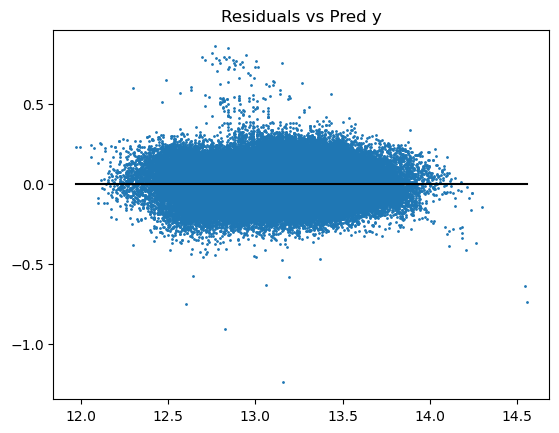

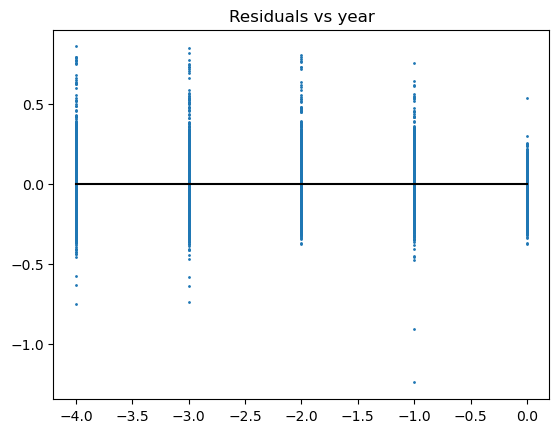

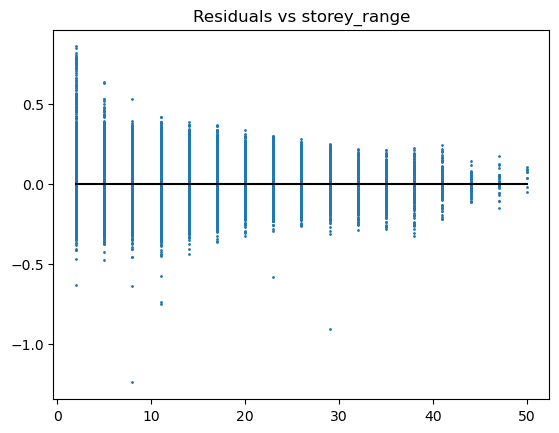

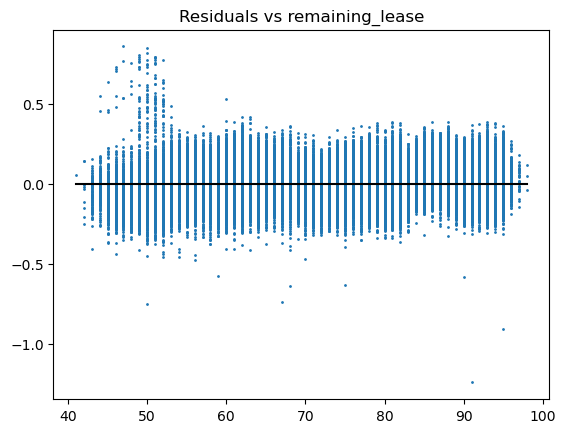

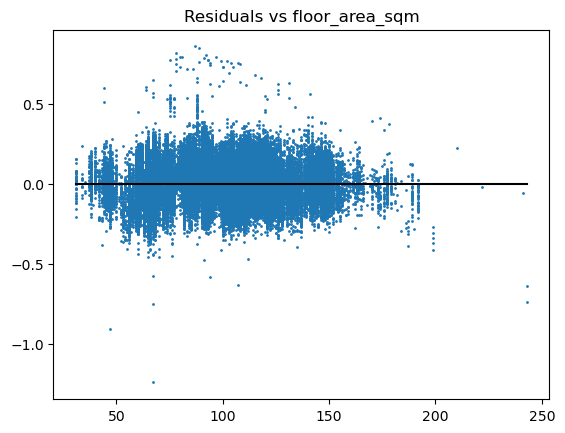

In [10]:
pred_y = linear_model.fittedvalues
plt.scatter(pred_y, linear_model.resid, s=1)
plt.plot([min(pred_y),max(pred_y)],[0,0], color='black')
plt.title('Residuals vs Pred y')
plt.show()

for var in ['year', 'storey_range', 'remaining_lease', 'floor_area_sqm']:
    plt.scatter(resales_after_2020[var], linear_model.resid, s=1)
    plt.plot([min(resales_after_2020[var]),max(resales_after_2020[var])],[0,0], color='black')
    plt.title(f'Residuals vs {var}')
    plt.show()
    
# In general no evidence of heteroscedasticity vs most variables, except perhaps storey_range.
# However, a model which includes storey_range**2 shows up with an insignificant coefficient.
# Should not affect our model.

### Train-test split by constructing rolling 4 year models to predict the 5th year

In [11]:
from sklearn.linear_model import LinearRegression

year_range = 4

for start_year in range(2015, current_year - year_range):
    train_df = new_resales_reg[(new_resales_reg['year'] >= start_year-current_year) & (new_resales_reg['year'] < start_year-current_year+year_range)]
    test_df = new_resales_reg[new_resales_reg['year'] == start_year-current_year+year_range]
    
    X_train = train_df.drop(columns=['resale_price']).to_numpy()
    y_train = train_df['resale_price'].to_numpy()
    X_test = test_df.drop(columns=['resale_price']).to_numpy()
    y_test = test_df['resale_price'].to_numpy()
    
    lm = LinearRegression()
    lm.fit(X_train, np.log(y_train))
    errors = lm.predict(X_test) - np.log(y_test)
    
    print(f'Model: {start_year}-{start_year+year_range-1} ({train_df.shape[0]} datapoints), Test {start_year+year_range} ({test_df.shape[0]} datapoints)')
    print(f'R2: {lm.score(X_train, np.log(y_train)):.3f}')
    print(f'Mean Error: {errors.mean():.3f}')
    print(f'SD Error: {errors.std():.3f}')
    print()
    
    
    # The 4-year models perform quite well on test data with mean error usually below 4%. 
    # SD of the errors are also about 10%.
    # Exception in 2021-2022 where the model underpredicted by about 10% on average,
    # suggesting an abnormal surge in house prices during Covid.

Model: 2015-2018 (61443 datapoints), Test 2019 (22186 datapoints)
R2: 0.877
Mean Error: -0.008
SD Error: 0.122

Model: 2016-2019 (83629 datapoints), Test 2020 (23333 datapoints)
R2: 0.876
Mean Error: -0.040
SD Error: 0.119

Model: 2017-2020 (87589 datapoints), Test 2021 (29087 datapoints)
R2: 0.878
Mean Error: -0.116
SD Error: 0.112

Model: 2018-2021 (96167 datapoints), Test 2022 (26720 datapoints)
R2: 0.877
Mean Error: -0.091
SD Error: 0.104

Model: 2019-2022 (101326 datapoints), Test 2023 (25771 datapoints)
R2: 0.888
Mean Error: 0.005
SD Error: 0.095

